<a href="https://colab.research.google.com/github/ttogle918/AI_projects/blob/master/sprint2_cinema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie revenue 예측

## 파일 가져오기 및 패키지 정의

In [1]:
# google 드라이브에 로컬 파일 업로드
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import re
from collections import Counter

In [3]:
import ast
def getDataFrame(s) :
  if s[0] == '\'' :
    s = s[1:-1]
  if str(s)[0] == '{' :
    df = pd.DataFrame([ast.literal_eval(s)])
  if str(s)[0] == '[' :
    df = pd.DataFrame(ast.literal_eval(s))
  else :
    df = s
  return df

### 1. 구글 드라이브에서 파일 불러오기



#### ? links와 links_small이 같은 내용인가? (중복되는 것이 있는가?)
#### ? ratings_small과 ratings가 같은 내용인가? (중복? 합쳐도 되는가?)
#### cast, crew, 등 안에 dataframe있는 것은 어떻게 해결? -> 데이터프레임을 따로 만들고 merge하자.
#### metadata는 무엇? 필요없는 것은 삭제하자! homepage는 boolean으로 해결(신뢰성때문에)




|  <center>credit</center> |  <center>cast</center> |
|:--------:|:--------|
|**credit** |cast(id, keywords), crew(credit_id, de), id> |
|**keywords** | id (id, name), keywords(id) |
|**links** | movieId, imdbId, tmdbId |
|**movies_metadata** | adult, belongs_to_collection, budget, genres |
|**''** | homepage, id, imdb_id, original_language |
|**''** | original_title, overview, popularity, poster_path |
|**''** | production_companies, production_countries |
|**''** | release_date, revenue, runtime, spoken_languages |
|**''** | status, tagline, title, video, vote_average, vote_count |
|**ratings** | userId, movieId, rating, timestamp |

## credits : 극 중 등장인물에 대한 정보와 제작진에 대한 정보를 담고있는 dataframe
이 credits의 데이터 중 우리는 배우의 이름과 책임 감독의 이름만 궁금할 것이다.

그러므로 cast에서는 상위 3명(주연), crew에서는 상위 1명(감독 혹은 작가)을 뽑아내었다.
#### 과연 주연과 감독/PD가 영화 판매수익에 영향을 미칠까?

1. data 불러오기
2. 중복된 값 지우기
3. null값 확인 -> 지우거나 고치거나
4. cast에서 배우 이름 따로 저장, crew에서 감독 이름 따로 저장

In [4]:
credits = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/credits.csv")

In [5]:
credits.duplicated().sum()

37

In [6]:
credits = credits.drop_duplicates()

In [7]:
print(credits.isnull().sum())
print('Empty cells: ' + str(len(credits[credits['cast'] == '[]'])) )

cast    0
crew    0
id      0
dtype: int64
Empty cells: 2414


In [8]:
print(credits.shape)
print(len(credits['id'].unique())) # id당 한 row가 아니다!

(45439, 3)
45432


In [9]:
credits.head(10)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
5,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",949
6,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",11860
7,"[{'cast_id': 2, 'character': 'Tom Sawyer', 'cr...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",45325
8,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",9091
9,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...",710


### cast

In [10]:
# string 형태로 data 형태 바꾸기
li = [entry['name'] for entry in  ast.literal_eval(credits.cast[0])[0:3]]
li

['Tom Hanks', 'Tim Allen', 'Don Rickles']

In [11]:
# cast 상위 4명만
import re

def set_list_to_string(s, idx, to) :
  if to == 0 :
    t_dict = ast.literal_eval(s)
    return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]
  
  t_dict = ast.literal_eval(s)[0:to]
  return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]

In [12]:
credits['actors'] = credits.cast.apply(set_list_to_string, idx='name', to=4)
credits['actors'].head(10)

0      [Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney]
1    [Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...
2    [Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...
3    [Whitney_Houston, Angela_Bassett, Loretta_Devi...
4    [Steve_Martin, Diane_Keaton, Martin_Short, Kim...
5    [Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Vo...
6    [Harrison_Ford, Julia_Ormond, Greg_Kinnear, An...
7    [Jonathan_Taylor_Thomas, Brad_Renfro, Rachael_...
8    [JeanClaude_Van_Damme, Powers_Boothe, Dorian_H...
9    [Pierce_Brosnan, Sean_Bean, Izabella_Scorupco,...
Name: actors, dtype: object

In [13]:
from collections import Counter

actor_count = Counter([name for names_per_film in credits.actors.values for name in names_per_film])
most_popular_actors = [entry[0] for entry in actor_count.most_common(20)]
most_popular_actors

['John_Wayne',
 'Jackie_Chan',
 'Robert_De_Niro',
 'Michael_Caine',
 'Gérard_Depardieu',
 'Christopher_Lee',
 'Nicolas_Cage',
 'Samuel_L_Jackson',
 'Susan_Sarandon',
 'Harvey_Keitel',
 'Bruce_Willis',
 'Donald_Sutherland',
 'Bette_Davis',
 'James_Mason',
 'Christopher_Walken',
 'Gene_Hackman',
 'Christopher_Plummer',
 'Alec_Baldwin',
 'Jeff_Bridges',
 'Danny_Glover']

In [14]:
credits['number_of_named_actors'] = credits['actors'].apply(len)

In [15]:
def listToString(item_list):
  return r' '.join(item_list)

credits['actors'] = credits['actors'].apply(listToString)

In [16]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=50)
corpus = [word for string in credits['actors'].values for word in string.split(' ')]
vectorizer.fit(corpus)
credits['actors_vec'] = credits['actors'].apply(lambda x: [x]).apply(vectorizer.transform)

In [17]:
credits['actors_vec'][4]

<1x98 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

### Crew

In [18]:
print('Empty cells: ' + str(len(credits[credits['crew'] == '[]'])))
print('Cells with NaN values: ' + str(credits.crew.isna().sum()))

Empty cells: 771
Cells with NaN values: 0


In [19]:
credits.crew[0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [20]:
[entry['name'] for entry in ast.literal_eval(credits.crew[0])]

['John Lasseter',
 'Joss Whedon',
 'Andrew Stanton',
 'Joel Cohen',
 'Alec Sokolow',
 'Bonnie Arnold',
 'Ed Catmull',
 'Ralph Guggenheim',
 'Steve Jobs',
 'Lee Unkrich',
 'Ralph Eggleston',
 'Robert Gordon',
 'Mary Helen Leasman',
 'Kim Blanchette',
 'Marilyn McCoppen',
 'Randy Newman',
 'Dale E. Grahn',
 'Robin Cooper',
 'John Lasseter',
 'Pete Docter',
 'Joe Ranft',
 'Patsy Bouge',
 'Norm DeCarlo',
 'Ash Brannon',
 'Randy Newman',
 'Roman Figun',
 'Don Davis',
 'James Flamberg',
 'Mary Beth Smith',
 'Rick Mackay',
 'Susan Bradley',
 'William Reeves',
 'Randy Newman',
 'Andrew Stanton',
 'Pete Docter',
 'Gary Rydstrom',
 'Karen Robert Jackson',
 'Chris Montan',
 'Rich Quade',
 'Michael Berenstein',
 'Colin Brady',
 'Davey Crockett Feiten',
 'Angie Glocka',
 'Rex Grignon',
 'Tom K. Gurney',
 'Jimmy Hayward',
 'Hal T. Hickel',
 'Karen Kiser',
 'Anthony B. LaMolinara',
 'Guionne Leroy',
 'Bud Luckey',
 'Les Major',
 'Glenn McQueen',
 'Mark Oftedal',
 'Jeff Pidgeon',
 'Jeff Pratt',
 'Stev

In [21]:
credits['crew'] = credits.crew.apply(set_list_to_string, idx='name', to=4)

In [22]:
credits.crew[0]

['John_Lasseter', 'Joss_Whedon', 'Andrew_Stanton', 'Joel_Cohen']

In [23]:
credits['crew'] = credits['crew'].apply(listToString)

In [24]:
credits['number_of_named_crews'] = credits['crew'].apply(len)

In [25]:
credits.head(3)

,cast,crew,id,actors,number_of_named_actors,actors_vec,number_of_named_crews
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney,4,"(0, 91)\t1",51
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,4,"(0, 81)\t1",59
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,4,"(0, 43)\t1\n (0, 94)\t1",65


In [26]:
vectorizer = CountVectorizer(min_df=50)
corpus = [word for string in credits['crew'].values for word in string.split(' ')]
vectorizer.fit(corpus)
credits['crews_vec'] = credits['crew'].apply(lambda x: [x]).apply(vectorizer.transform)

In [27]:
credits['crews_vec'][4]

<1x103 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [29]:
credits = credits.drop(['cast'], axis=1)

### EDA를 거친 credits 모습

In [30]:
credits.head(3)

,crew,id,actors,number_of_named_actors,actors_vec,number_of_named_crews,crews_vec
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney,4,"(0, 91)\t1",51,"(0, 56)\t1"
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,4,"(0, 81)\t1",59,"(0, 48)\t1"
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,4,"(0, 43)\t1\n (0, 94)\t1",65,


## keywords : 극 중 키워드 단어를 담고있는 dataframe
-> keyword_name에 극 중 키워드 단어를 처리하기 쉬운 형태로 저장한다.

#### 과연 키워드가 영화 판매수익에 영향을 미칠까?

In [42]:
keywords = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/keywords.csv")

In [43]:
print(keywords.shape)
keywords.head(1)

(46419, 2)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


In [44]:
[entry['name'] for entry in  ast.literal_eval(keywords.keywords[0])]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [45]:
keywords['keywords'] = keywords.keywords.apply(set_list_to_string, idx='name', to=0)

In [46]:
keywords.head(3)

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board_game, disappearance, based_on_childrens..."
2,15602,"[fishing, best_friend, duringcreditsstinger, o..."


In [47]:
keyword_zip = []
keyword_zip = keyword_zip.append(keywords['keywords'].iloc[1])
print(keyword_zip)

None


In [ ]:
keywords['keywords'] = keywords['keywords'].apply(listToString)
keywords.head(3)

,id,keywords
0,862,jealousy toy boy friendship friends rivalry bo...
1,8844,board_game disappearance based_on_childrens_bo...
2,15602,fishing best_friend duringcreditsstinger old_men


In [ ]:
keywords['keywords'].unique()

array(['jealousy toy boy friendship friends rivalry boy_next_door new_toy toy_comes_to_life',
       'board_game disappearance based_on_childrens_book new_home recluse giant_insect',
       'fishing best_friend duringcreditsstinger old_men', ...,
       'blair_witch', 'witch mythology legend serial_killer mockumentary',
       'artist play pinoy'], dtype=object)

## links : 극 중 키워드 단어를 담고있는 dataframe
-> keyword_name에 극 중 키워드 단어를 처리하기 쉬운 형태로 저장한다.

#### 과연 키워드가 영화 판매수익에 영향을 미칠까?

In [ ]:
links = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links.csv")
print(links.shape)
links = links.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links_small.csv"))

(45843, 3)


In [ ]:
print(links.shape)
links.head(1)

(54968, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0


In [ ]:
links = links.drop_duplicates()

In [ ]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     222
dtype: int64

## movies_metadata : 영화에 대한 정보를 담고있는 dataframe
-> 예측할 때 필요한 정보만 남겨놓았다.

#### 과연 예산과 장르, 상영시간, 판매회사가 영화 판매수익에 영향을 미칠까?

+ movies_metadata에서 필요없는 컬럼 삭제 ( ['original_language', 'original_title', 'overview', 'poster_path', 'tagline'] )
+ homepage컬럼은 유/무로 판단(있다면 1, 없다면 0)
+ spoken_languages는 언어가 몇가지인지로 적는다. ( 이 영화에 대한 기대감과 투자의 정도를 알 수 있을 것이다. )

In [ ]:
movies_metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/movies_metadata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
movies_metadata.duplicated().sum()

13

In [ ]:
movies_metadata = movies_metadata.drop_duplicates()

In [ ]:
print(movies_metadata.shape)
movies_metadata.head(2)

(45453, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [ ]:
movies_metadata.isnull().sum()

adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [ ]:
movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [ ]:
def toint(s) :
  try :
    n = int(s)
    return n
  except :
    print(s)
    return s
movies_metadata.budget.apply(toint)

/ff9qCepilowshEtG2GYWwzt2bs4.jpg
/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
/zaSf5OG7V8X8gqFvly88zDdRm46.jpg


0        30000000
1        65000000
2               0
3        16000000
4               0
           ...   
45461           0
45462           0
45463           0
45464           0
45465           0
Name: budget, Length: 45453, dtype: object

In [ ]:
# 본인의 columns 위치가 아닌 곳에 데이터가 있는 data들 drop
movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/ff9qCepilowshEtG2GYWwzt2bs4.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zaSf5OG7V8X8gqFvly88zDdRm46.jpg'].index)
print(movies_metadata.shape)

(45450, 24)


In [ ]:
movies_metadata.poster_path = movies_metadata.poster_path.fillna(0)

In [ ]:
def set_poster(s) :
  if s == 0 :
    return 0
  else :
    return 1
  return 0
movies_metadata.poster_path = movies_metadata.poster_path.apply(set_poster)
movies_metadata.columns = ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count']
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
print(movies_metadata.adult.unique())
print(movies_metadata.status.unique())
print(movies_metadata.video.unique())

['False' 'True']
['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']
[False True nan]


In [ ]:
# False가 대부분이고, True는 극소수(대략 0.02%)이므로 통계적으로 의미를 띄지않는다.(유의미하지않다.) -> drop
Counter(movies_metadata.adult)

Counter({'False': 45441, 'True': 9})

In [ ]:
# belongs_to_collection 컬럼에 빈칸(nan)값이 많기 때문에 우리가 예측하고자 하는 바에 도움이 되지 않는다. -> drop
movies_metadata.shape, movies_metadata.belongs_to_collection.isnull().sum()

((45450, 24), 40959)

In [ ]:
Counter(movies_metadata.status)

Counter({'Canceled': 2,
         'In Production': 20,
         'Planned': 15,
         'Post Production': 98,
         'Released': 45002,
         'Rumored': 229,
         nan: 84})

In [ ]:
Counter(movies_metadata.video)

Counter({False: 45354, True: 93, nan: 3})

In [ ]:
len(movies_metadata[ (movies_metadata['revenue'] == 0) ])

38041

In [ ]:
movies_metadata[ (movies_metadata['video'] == False) ].revenue

0        373554033.0
1        262797249.0
2                0.0
3         81452156.0
4         76578911.0
            ...     
45461            0.0
45462            0.0
45463            0.0
45464            0.0
45465            0.0
Name: revenue, Length: 45354, dtype: float64

Text(0, 0.5, 'revenue')

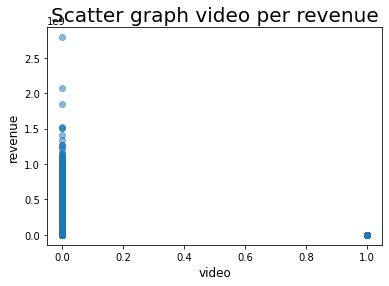

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(movies_metadata['video'], movies_metadata['revenue'], alpha = .5)
plt.title('Scatter graph video per revenue', fontsize=20)
plt.xlabel('video', fontsize=12)
plt.ylabel('revenue', fontsize=12)

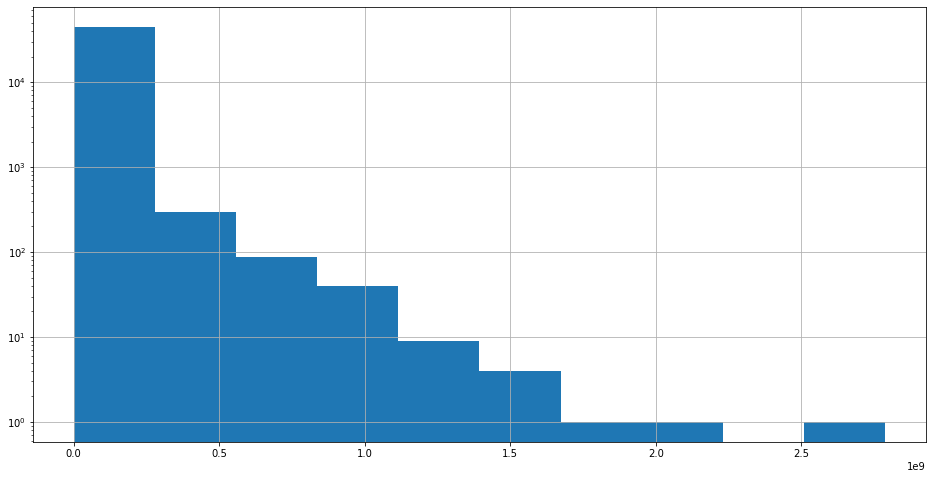

In [ ]:
movies_metadata[movies_metadata['video']==False].revenue.hist(figsize=(16,8), log=True);

In [ ]:
# 출시 예정 상태의 영화에 대해서 예측할 예정이다. -> 나중에 분리
# test_movies_metadata = movies_metadata[(movies_metadata['status'] == 'Planned') | (movies_metadata['status'] == 'In Production')]
# print(test_movies_metadata.status.unique())

In [ ]:
# 출시된 상태의 영화에 대해서 훈련시킬 예정이다.
movies_metadata = movies_metadata[ (movies_metadata['status'] == 'Released') | (movies_metadata['status'] == 'Planned') | (movies_metadata['status'] == 'In Production')]
print(movies_metadata.status.unique())

['Released' 'In Production' 'Planned']


In [ ]:
movies_metadata.describe(include='all')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
count,45037,4472,45037,45037,7715,45037,45022,45027,45037,44113,45037,45037.000000,45037,45037,44956,4.503700e+04,44784.000000,45037,45037,20305,45037,45037,45037.000000,45037.000000
unique,2,1691,1219,4048,7610,45020,45005,89,42988,43929,43803,NaN,22592,2378,17279,NaN,NaN,1918,3,20182,41920,2,NaN,NaN
top,False,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",0,"[{'id': 18, 'name': 'Drama'}]",http://www.georgecarlin.com,10991,tt0046468,en,Alice in Wonderland,No overview found.,0.0,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-01-01,NaN,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Cinderella,False,NaN,NaN
freq,45028,29,36173,4941,12,2,2,31971,8,133,33,NaN,11640,17743,135,NaN,NaN,22221,45002,7,11,44944,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991696,NaN,NaN,NaN,1.131311e+07,94.248392,NaN,NaN,NaN,NaN,NaN,5.623321,110.842152
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090750,NaN,NaN,NaN,6.462451e+07,38.377917,NaN,NaN,NaN,NaN,NaN,1.916475,493.507790
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000e+00,85.000000,NaN,NaN,NaN,NaN,NaN,5.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000e+00,95.000000,NaN,NaN,NaN,NaN,NaN,6.000000,10.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000e+00,107.000000,NaN,NaN,NaN,NaN,NaN,6.800000,35.000000


imdb_id는 id값이기 때문에 실제 값으로 보기 힘들다. ->drop

vote_count도 count한 통계결과이기 때문에 유의미하지않다. ->drop

### **여기부터!!!**

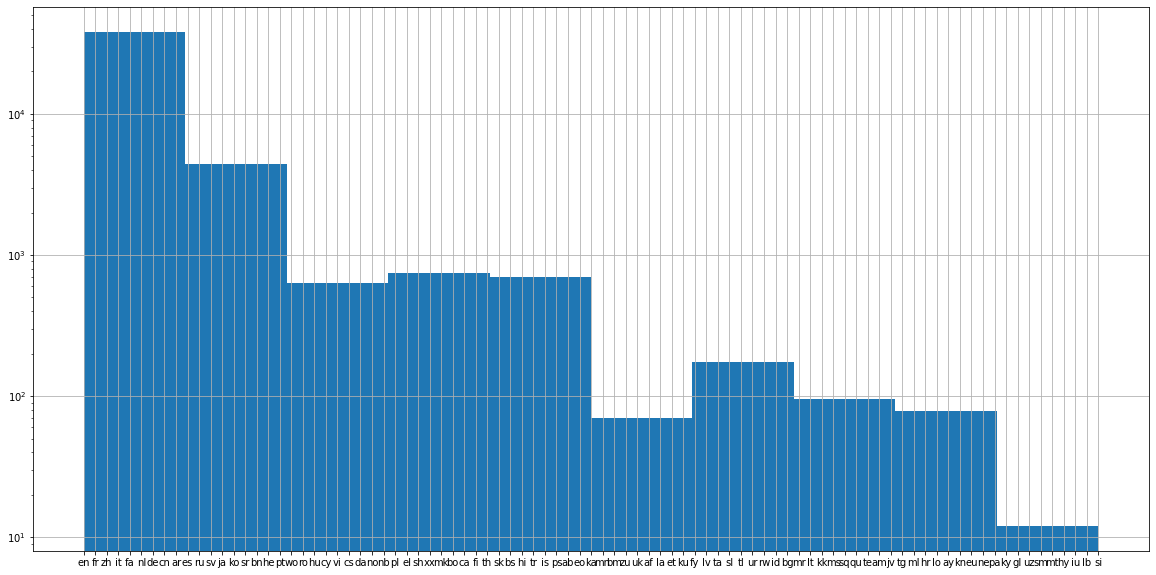

In [ ]:
movies_metadata['original_language'].hist(figsize=(20,10), log=True);

In [ ]:
movies_metadata = movies_metadata.drop(['adult','belongs_to_collection', 'imdb_id', 'vote_count', 'original_language', 'original_title', 'overview', 'tagline'], axis=1)
movies_metadata.head(2)

,budget,genres,homepage,id,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,21.9469,1,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,17.0155,1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9


In [ ]:
movies_metadata['video'] = movies_metadata['video'].fillna(False)

In [ ]:
def setHomepage(s) :
  if s == 0 :
    return 0
  s = str(s)
  if s[0:4] == 'http' :
    return 1
  return 0
movies_metadata.fillna(0) # homepage가 없는 경우 0
movies_metadata.homepage = movies_metadata.homepage.apply(setHomepage)

In [ ]:
def setLen(s) :
  df = getDataFrame(s)
  n = df.shape[0]
  return n
movies_metadata.spoken_languages = movies_metadata.spoken_languages.apply(setLen)
movies_metadata.spoken_languages.head(5)

In [ ]:
movies_metadata.isnull().sum()

In [ ]:
print(movies_metadata.runtime.min())
print(movies_metadata.runtime.max())
print(len(movies_metadata[movies_metadata.runtime < 60]))

In [ ]:
movies_metadata = movies_metadata.drop( movies_metadata[movies_metadata['runtime'] < 60 ].index)
print(movies_metadata.shape)
movies_metadata.head(2)

## ratings : 영화에 대한 평점을 담고있는 dataframe
-> 예측할 때 필요한 정보만 남겨놓았다.

#### 과연 ?

In [48]:
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings.csv")
ratings = ratings.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings_small.csv"))

In [49]:
print(ratings.shape)
ratings.head(1)

(26124293, 4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529


In [50]:
ratings = ratings.drop_duplicates(ignore_index=True)
print(ratings.shape)

(26124293, 4)


In [51]:
# ratings = ratings.drop_duplicates(ignore_index=True)
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
# movies_metadata['id'], movies_metadata['name'] = movies_metadata.belongs_to_collection.apply(getDataFrame)
# movies_metadata.head(3)

In [56]:
ratings.groupby(by="movieId").mean()

,userId,rating,timestamp
movieId,,,
1,134618.571746,3.888099,1.113401e+09
2,134327.725685,3.237628,1.088542e+09
3,136004.085048,3.175495,9.661129e+08
4,135659.481964,2.873580,9.389754e+08
5,134799.710526,3.080253,9.897045e+08
...,...,...,...
176267,189131.000000,4.000000,1.501746e+09
176269,97528.000000,3.500000,1.501765e+09
176271,837.000000,5.000000,1.501766e+09
